In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import LSsurf
import pointCollection as pc
import scipy.sparse as sp
import sparseqr
#%matplotlib widget

# Introduction

This notebook demonstrates a smooth grid-fit solution incorporating a vector field that specifies an anisotropic direction for the interpolation.  The output grid will be preferentially smoothed in this direction.

The basic isotropic case minimizes
$$
||\mathbf{d}(x) - \mathbf{m}(x)||^2 + \int \nabla^4 \mathbf{m} + ||\mathbf{m}||^2 dA
$$
Here $\mathbf{d}(x)$ represents a set of data points, $\mathbf{m}$ represents a model fit to those data points, and $\nabla^4$ represents the sum of the squared second derivatives of a function.

We demonstrate the impulse response of this solution by fitting a single data point at the origin:


In [3]:
# def ine the data point
data=pc.data().from_dict({'x':np.array([0]),'y':np.array([0]),'z':np.array([1]), 'sigma':np.array([0.1])})


# define the model domain:
bds={'x':[-10, 10],
        'y':[-10, 10]}
spacing={'z0':0.05}
grids={'z0':LSsurf.fd_grid( [bds['y'], bds['x']], spacing['z0']*np.ones(2))}

# operator that interpolates the data point from the grid:
G_data = LSsurf.lin_op(grids['z0'], name='interp_z').interp_mtx(data.coords()[0:2])

In [4]:

# isotropic constraint: operator that calculates the second derivatives of a function (i.e. grad2 m(x, y))
E_RMS={'d2z0_dx2':0.5}
root_delta_A_z0=np.sqrt(np.prod(grids['z0'].delta))
grad2_z0=LSsurf.lin_op(grids['z0'], name='grad2_z0').grad2(DOF='z0')
grad2_z0.expected=E_RMS['d2z0_dx2']/root_delta_A_z0*np.ones(grad2_z0.N_eq)


In [5]:
# zero model constraint: operator that returns the value of a function (i.e. m(x, y))
E_RMS['z0']= 0.5
mag_z0=LSsurf.lin_op(grids['z0'], name='mag_z0').one(DOF='z0')
mag_z0.expected=E_RMS['z0']/root_delta_A_z0*np.ones_like(mag_z0.v.ravel())


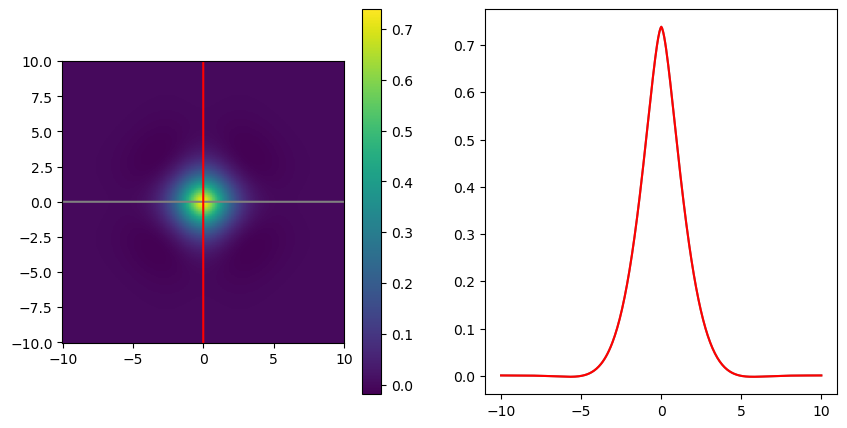

In [6]:
# isotropic solution:
# stack the constraint equations
Gc = LSsurf.lin_op(None, name='constraints').vstack([grad2_z0, mag_z0])
# stack the interpolation operator and the constraints
Gcoo=sp.vstack([G_data.toCSR(), Gc.toCSR()]).tocoo()

# collect the expected deviations
E = np.concatenate([data.sigma.ravel(), grad2_z0.expected.ravel(), mag_z0.expected.ravel()])

# collect the expected values
rhs = np.concatenate([data.z.ravel(), np.zeros([Gc.shape[0]])], axis=0)

N_eq = rhs.size
# convert the expected values into a diagnonal matrix of inverse uncertainties
TCinv=sp.dia_matrix((1/E,0), shape=(N_eq, N_eq))

# solve for the model using a QR transform (hidden in spareqr.solve).  TCinv scales each side by its expected
# value
m0=sparseqr.solve(TCinv.dot(Gcoo), TCinv.dot(rhs)).reshape(grids['z0'].shape)

m={}
m['isotropic'] = pc.grid.data().from_dict({'x':grids['z0'].ctrs[1], 
                                           'y':grids['z0'].ctrs[0],
                                           'z':m0})

# plot the solution, and two sample profiles
theta = 0

samp_profile = pc.data().from_dict({'dist':np.arange(-10, 10, 0.01)})
samp_profile.assign(x = samp_profile.dist * np.cos(theta))
samp_profile.assign(y = samp_profile.dist * np.sin(theta))
samp_profile.assign(xp = samp_profile.dist * np.sin(theta))
samp_profile.assign(yp = samp_profile.dist* -np.cos(theta))

hf, hax=plt.subplots(1,2, figsize=[10,5])
plt.sca(hax[0])
plt.colorbar(m['isotropic'].show())
plt.plot(samp_profile.x, samp_profile.y,color='gray')
plt.plot(samp_profile.xp, samp_profile.yp,color='red')

plt.sca(hax[1])
plt.plot(samp_profile.dist, m['isotropic'].interp(samp_profile.x, samp_profile.y), color='gray')
plt.plot(samp_profile.dist, m['isotropic'].interp(samp_profile.xp, samp_profile.yp), color='red')



# Anisotropic solution

Next we'll demonstrate how to minimize a function in a direction specified by a grid.
For this we'll need a directional second-derivative operator.  If we let $\vec{u}$ be a unit-magnitude direction field,  the derivative operator parallel to $\vec{u}$ is:
$$
\nabla_u = \vec{u} \cdot \nabla = u\partial/\partial x + v \partial/\partial y
$$
so 
$$
\nabla^2_u  = ( \vec{u} \cdot \nabla ) ( \vec{u} \cdot \nabla) = u^2\partial^2/\partial x^2 + uv \partial^2/\partial x \partial y + v^2 \partial^2/\partial y^2
$$
here $u$ and $v$ are the components of vector field $\vec{u}$.  Note that we have ignored the derivatives of $\vec{u}$, which may account for some of the fuzziness seen in the results below where there is a gradient in the direction field.


Similar to the isotropic case, we minimize:

$$
   ||\mathbf{d}(x) - \mathbf{m}(x)||^2 + \int ||\nabla_u^2\mathbf{m}|| + ||\mathbf{m}||^2 dA
$$



We will define a vector field in a uniform direction to show how this works.



In [7]:
# function to ensure that the rows of different equations line up properly:

def make_system_of_ops(stencils):
    all_offsets=set()

    for stencil in stencils.values():
        this = set( tuple(jj) for jj in zip(*stencil[0]))
        all_offsets.update(this)
    for stencil in stencils.values():
        stencil[1] = list(stencil[1])
        set_offset = set( tuple(jj) for jj in zip(*stencil[0]))
        for offset in all_offsets:
            if offset not in set_offset:
                for dim, oo in enumerate(offset):
                    stencil[0][dim].append(oo)
                stencil[1].append(0)
        stencil[1] = np.array(stencil[1]) 


In [8]:
# function to scale an operator by a field interpolated from a grid:

def scale_op_by_2d_grid(op, data_grid, field='z', column=None, power=None):
    temp = list(np.unravel_index(op.ind0-op.grid.col_0, op.grid.shape))
    for dim in range(len(temp)):
        # convert indices to node locations using the grid's corner location and spacing
        temp[dim] = op.grid.bds[dim][0] + op.grid.delta[dim]*temp[dim]
        # if no column was specified, average the operator's node locations
        # Could add a weighted average based on values
        if column is None:
            if temp[dim].ndim > 1:
                temp[dim] = np.mean(temp[dim], axis=1)
        else:
            temp[dim] = temp[dim][:, column]
    # interpolate the grid at the average node locations
    zi = data_grid.interp(temp[1], temp[0], field=field)
    if power is not None:
        zi=zi**power
    # scale the coefficients:
    if op.v.ndim==1:
        op.v *= zi
    else:
        for col in range(op.v.shape[1]):
            op.v[:,col] *= zi
    return op
    

In [9]:

def directional_smoothing_op(grid, u):
    """
    make a directional smoothing LSsurf.lin_op

    inputs:
        grid: LSsurf.grid
            grid on which the operator is defined
        u: pointCollection.grid.data
            direction grid, containing a u and a v field
    returns:
        Axy: LSsurf.lin_op
            linear operator that calculates the directional derivative of a field.
    """
    
    # operators that are needed to build the directional derivative
    coeffs=np.array([-1., 2., -1.])/(grid.delta[0]**2)
    stencils = {
        'd2zdx2' : [([0, 0, 0],[-1, 0, 1]), coeffs],
        'd2zdy2' : [([-1, 0, 1],[0, 0, 0]), coeffs],
        'd2zdxdy' : [([-1, -1, 1,1],[-1, 1, -1, 1]), np.array([-1., 1., 1., -1])/(4*grid.delta[0]**2)]
    }
    make_system_of_ops(stencils)

    # build the directional second-derivative operator:
    Axy =  LSsurf.lin_op(grid=grid).diff_op( *stencils['d2zdx2'])
    scale_op_by_2d_grid(Axy, u, field='u', power=2)
    temp = LSsurf.lin_op(grid=grid).diff_op( *stencils['d2zdxdy'])
    scale_op_by_2d_grid(temp, u, field='v')
    scale_op_by_2d_grid(temp, u, field='u')
    temp.v *= 2
    Axy.add(temp)
    temp=LSsurf.lin_op(grid=grid).diff_op( *stencils['d2zdy2'])
    scale_op_by_2d_grid(temp, u, field='v', power=2)
    Axy.add(temp)
    
    return Axy

In [10]:
# operators that are needed to build the directional derivative
coeffs=np.array([-1., 2., -1.])/(grids['z0'].delta[0]**2)
stencils = {
    'd2zdx2' : [([0, 0, 0],[-1, 0, 1]), coeffs],
    'd2zdy2' : [([-1, 0, 1],[0, 0, 0]), coeffs],
    'd2zdxdy' : [([-1, -1, 1,1],[-1, 1, -1, 1]), np.array([-1., 1., 1., -1])/(4*grids['z0'].delta[0]**2)]
}
make_system_of_ops(stencils)


In [11]:
#  Define the vector field (here just parallel to direction theta)


# arbitrary direction parallel to which the surface will be smooth
theta=65*np.pi/180

# make a grid from which the direction can be interpolated
x_for_u = np.arange(-10, 10.1, .25)

u=pc.grid.data().from_dict({'x':x_for_u,
                            'y':x_for_u,
                            'u':np.zeros([len(x_for_u), len(x_for_u)])+np.cos(theta),
                            'v':np.zeros([len(x_for_u), len(x_for_u)])+np.sin(theta)})

# define profiles parallel and perpendicular to the vector field:
samp_profile = pc.data().from_dict({'dist':np.arange(-10, 10, 0.01)})
samp_profile.assign(x = samp_profile.dist * np.cos(theta))
samp_profile.assign(y = samp_profile.dist * np.sin(theta))
samp_profile.assign(xp = samp_profile.dist * np.sin(theta))
samp_profile.assign(yp = samp_profile.dist* -np.cos(theta))


<class 'pointCollection.data.data'> with shape (2000,),
with fields:
['dist', 'x', 'y', 'xp', 'yp']

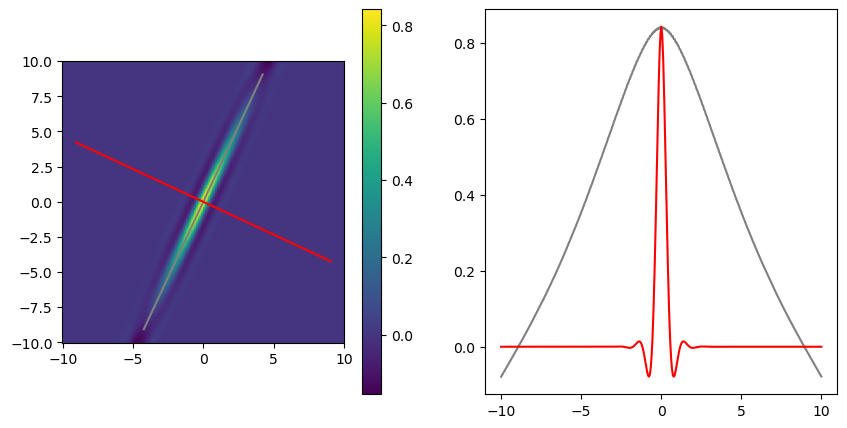

In [12]:
# define a weight for the directional smoothing:
E_RMS['d2z0_dx2_aniso'] = 1


# calculate the directional smoothing operator for the velocity field
Axy = directional_smoothing_op(grids['z0'], u)
Axy.expected = np.zeros(Axy.shape[0])+E_RMS['d2z0_dx2_aniso']

Gc = LSsurf.lin_op(None, name='constraints').vstack([Axy, mag_z0])

# make the sparse design matrix
Gcoo=sp.vstack([G_data.toCSR(), Gc.toCSR()]).tocoo()

E = np.concatenate([data.sigma.ravel(), Axy.expected.ravel(), mag_z0.expected.ravel()])

rhs = np.concatenate([data.z.ravel(), np.zeros([Gc.shape[0]])], axis=0)

N_eq = rhs.size
TCinv=sp.dia_matrix((1/E,0), shape=(N_eq, N_eq))
ma=sparseqr.solve(TCinv.dot(Gcoo), TCinv.dot(rhs)).reshape(grids['z0'].shape)

m['aniso'] = pc.grid.data().from_dict({'x':grids['z0'].ctrs[1],
                                             'y':grids['z0'].ctrs[0],
                                             'z': ma})

hf, hax=plt.subplots(1,2, figsize=[10,5])
plt.sca(hax[0])
plt.colorbar(m['aniso'].show())
plt.plot(samp_profile.x, samp_profile.y, color='gray')
plt.plot(samp_profile.xp, samp_profile.yp, color='red')

plt.sca(hax[1])
plt.plot(samp_profile.dist, m['aniso'].interp(samp_profile.x, samp_profile.y), color='gray')
plt.plot(samp_profile.dist, m['aniso'].interp(samp_profile.xp, samp_profile.yp), color='red')


This shows that the impulse response for the interpolator is elongated parallel to the direction of anisotropy.  The plots along and across the velocity direction show that the impulse response is several times broader in the direction specified $\vec{u}$.

For theta=0 or theta=90, the impulse response is very much more strongly elongated, because the derivative can be precisely described by a finite difference formula for these orientations.  For other directions, the representation of the directional derivative is less precise, and the impulse response is broader.  This is less important when interpolating real data than it would seem from the impulse response alone, because real data seldom contain features as sharp as the impulse response.


For a more complicated example, we can try to interpolate a point in a circular field:

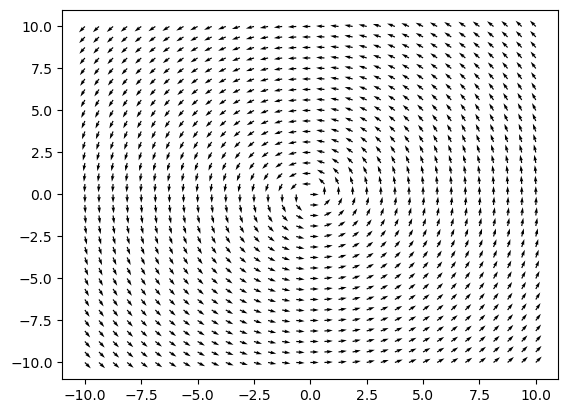

In [13]:

# make a velocity field going around in a circle
xg, yg = np.meshgrid(np.arange(-10, 10.01, 0.125), np.arange(-10, 10.01, 0.125))
zg = np.abs(xg+1j*yg)
vp, up = np.gradient(zg)
uv = 1j*(up+1j*vp)
# need a nonzero velocity in the center to avoid dividing by zero
uv[np.abs(uv)==0]=1
uv /= np.abs(uv)
u = pc.grid.data().from_dict({'x':xg[0,:],
                              'y':yg[:,0],
                              'u':np.real(uv),
                              'v':np.imag(uv)})


plt.figure()
plt.quiver(xg[::5,::5], yg[::5, ::5], u.u[::5, ::5], u.v[::5, ::5])

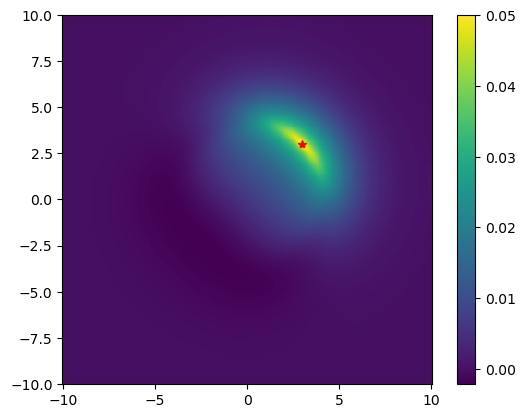

In [14]:
Axy = directional_smoothing_op(grids['z0'], u)

# calculate a rotated second-derivative operator for this velocity field.
E_RMS['d2z0_dx2_aniso'] = 0.25
Axy.expected = E_RMS['d2z0_dx2_aniso'] + np.zeros(Axy.shape[0])


# make a data structure for a point offset from the origin
data_s=pc.data().from_dict({'x':np.array([3]),
                          'y':np.array([3]),
                          'z':np.array([1]),
                          'sigma':np.array([0.1])})

mag_z0.expected[:]=2

G_data_s = LSsurf.lin_op(grids['z0'], name='interp_z').interp_mtx(data_s.coords()[0:2])
Gc = LSsurf.lin_op(None, name='constraints').vstack([Axy, mag_z0])
Gcoo=sp.vstack([G_data_s.toCSR(), Gc.toCSR()]).tocoo()

E = np.concatenate([data_s.sigma.ravel(), Axy.expected.ravel(), mag_z0.expected.ravel()])

rhs = np.concatenate([data_s.z.ravel(), np.zeros([Gc.shape[0]])], axis=0)

N_eq = rhs.size
TCinv=sp.dia_matrix((1/E,0), shape=(N_eq, N_eq))
ma=sparseqr.solve(TCinv.dot(Gcoo), TCinv.dot(rhs)).reshape(grids['z0'].shape)

m['circ'] = pc.grid.data().from_dict({'x':grids['z0'].ctrs[1],
                                             'y':grids['z0'].ctrs[0],
                                             'z': ma})

plt.figure()
plt.colorbar(m['circ'].show())
plt.plot(data_s.x, data_s.y,'r*')


We can see that the interpolation is somewhat circular.  This is more impressive if we have several points to interpolate:

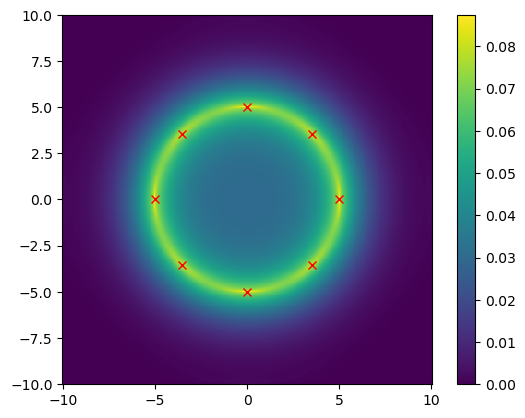

In [15]:
pts = 5*np.exp(1j*np.arange(0, 2*np.pi, np.pi/4))
data_c = pc.data().from_dict({'x':np.real(pts),
                            'y':np.imag(pts),
                            'z':np.ones(pts.shape),
                            'sigma':0.1*np.ones(pts.shape)})

G_data_c = LSsurf.lin_op(grids['z0'], name='interp_z').interp_mtx(data_c.coords()[0:2])
Gc = LSsurf.lin_op(None, name='constraints').vstack([Axy, mag_z0])
Gcoo=sp.vstack([G_data_c.toCSR(), Gc.toCSR()]).tocoo()

E = np.concatenate([data_c.sigma.ravel(), Axy.expected.ravel(), mag_z0.expected.ravel()])

rhs = np.concatenate([data_c.z.ravel(), np.zeros([Gc.shape[0]])], axis=0)

N_eq = rhs.size
TCinv=sp.dia_matrix((1/E,0), shape=(N_eq, N_eq))
ma=sparseqr.solve(TCinv.dot(Gcoo), TCinv.dot(rhs)).reshape(grids['z0'].shape)

m['circ_many'] = pc.grid.data().from_dict({'x':grids['z0'].ctrs[1],
                                             'y':grids['z0'].ctrs[0],
                                             'z': ma})

plt.figure()
plt.colorbar(m['circ_many'].show())
plt.plot(data_c.x, data_c.y,'rx')




The smear that is visible in the impulse response is quite pronounced here, and it may have to do with not including the derivatives of the direction field in $A_{xy}$.  It might also help to use a higher-order approximation of the derivative in deriving $A_{xy}$.

Compare this to the isotropic case.  In the cell below, try a few different values of E_RMS{'d2z0dx2'}.

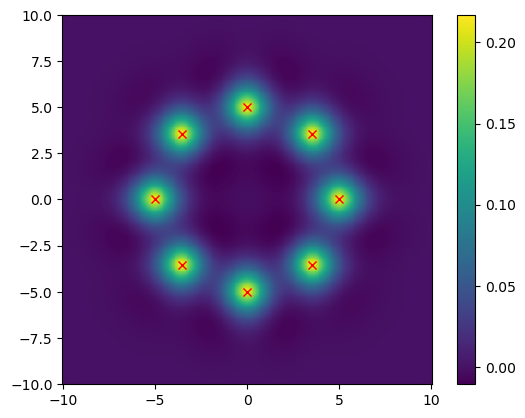

In [16]:
# isotropic solution:

E_RMS={'d2z0_dx2':0.25}
grad2_z0.expected=E_RMS['d2z0_dx2']/root_delta_A_z0*np.ones(grad2_z0.N_eq)


# stack the constraint equations
Gc = LSsurf.lin_op(None, name='constraints').vstack([grad2_z0, mag_z0])
# stack the interpolation operator and the constraints
Gcoo=sp.vstack([G_data_c.toCSR(), Gc.toCSR()]).tocoo()

# collect the expected deviations
E = np.concatenate([data_c.sigma.ravel(), grad2_z0.expected.ravel(), mag_z0.expected.ravel()])

# collect the expected values
rhs = np.concatenate([data_c.z.ravel(), np.zeros([Gc.shape[0]])], axis=0)

N_eq = rhs.size
# convert the expected values into a diagnonal matrix of inverse uncertainties
TCinv=sp.dia_matrix((1/E,0), shape=(N_eq, N_eq))

# solve for the model using a QR transform (hidden in spareqr.solve).  TCinv scales each side by its expected
# value
m0=sparseqr.solve(TCinv.dot(Gcoo), TCinv.dot(rhs)).reshape(grids['z0'].shape)

m={}
m['isotropic_circle'] = pc.grid.data().from_dict({'x':grids['z0'].ctrs[1], 
                                           'y':grids['z0'].ctrs[0],
                                           'z':m0})
plt.figure()
plt.colorbar(m['isotropic_circle'].show())
plt.plot(data_c.x, data_c.y,'rx')
